# Reconstruct probability distributions using circuit cutting

In [1]:
import numpy as np

from qiskit.circuit import QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import EfficientSU2

from circuit_knitting.cutting import cut_gates
from circuit_knitting.cutting.cutting_experiments import (
    generate_distribution_cutting_experiments,
)
from circuit_knitting.cutting.cutting_reconstruction import reconstruct_distribution


def construct_circuit(
    num_qubits: int, num_measurements: int, reps: int = 1
) -> tuple[QuantumCircuit, QuantumCircuit]:
    circuit = EfficientSU2(
        num_qubits=num_qubits, reps=reps, entanglement="circular"
    ).decompose()
    circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)

    circuit.add_register(ClassicalRegister(num_measurements))
    for i in range(num_measurements):
        circuit.measure(i, i)

    cut_indices = [
        i
        for i, instruction in enumerate(circuit.data)
        if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, num_qubits - 1}
    ]
    circuit1, bases = cut_gates(circuit, cut_indices)

    return circuit, circuit1, bases

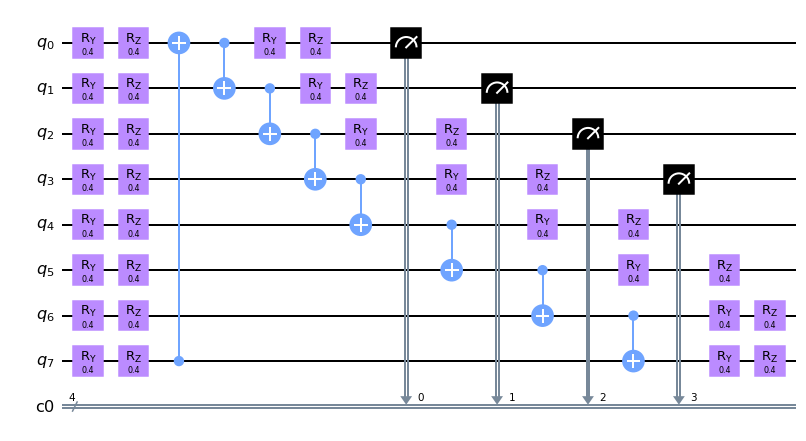

In [2]:
circuit0, circuit1, bases = construct_circuit(8, 4)
circuit0.draw("mpl", fold=-1)

In [3]:
subexperiments, coefficients = generate_distribution_cutting_experiments(
    circuit1, np.inf
)
coefficients

[(0.5, <WeightType.EXACT: 1>),
 (0.5, <WeightType.EXACT: 1>),
 (0.5, <WeightType.EXACT: 1>),
 (-0.5, <WeightType.EXACT: 1>),
 (0.5, <WeightType.EXACT: 1>),
 (-0.5, <WeightType.EXACT: 1>)]

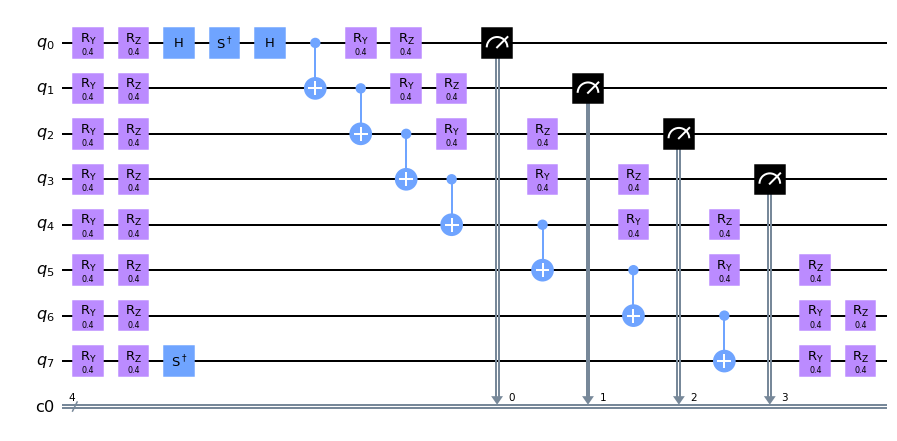

In [4]:
subexperiments[0].draw("mpl")

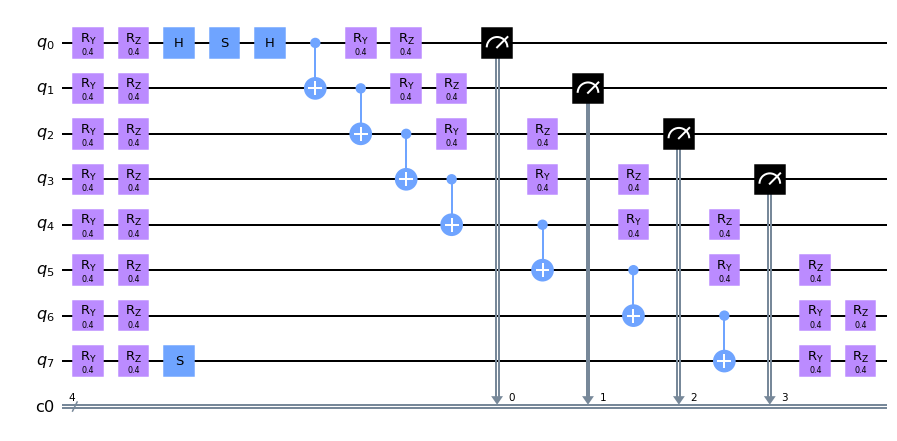

In [5]:
subexperiments[1].draw("mpl")

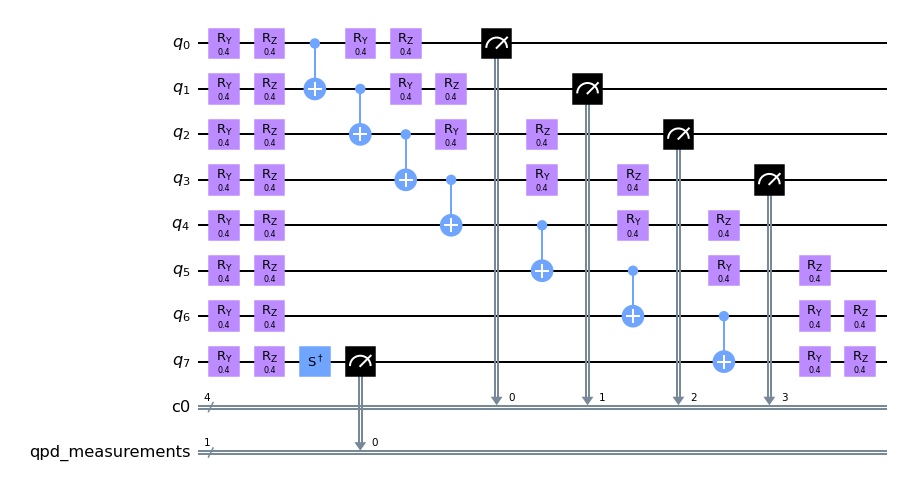

In [6]:
subexperiments[2].draw("mpl")

In [7]:
from circuit_knitting.utils.simulation import ExactSampler
from qiskit_aer.primitives import Sampler as AerSampler


def sampler_simulator(circuits, shots=None):
    if shots is None:
        sampler = ExactSampler()
    else:
        sampler = AerSampler(run_options={"shots": shots})
    return sampler.run(circuits).result()

In [8]:
shots = 100_000

In [9]:
overhead = np.prod([basis.overhead for basis in bases])
overhead

9.0

In [10]:
results = sampler_simulator(subexperiments, shots * overhead)
results.quasi_dists

[{10: 0.0013611111111111111,
  6: 0.0020911111111111113,
  7: 0.03314888888888889,
  1: 0.02322888888888889,
  8: 0.028251111111111112,
  12: 0.020966666666666668,
  0: 0.30828444444444447,
  15: 0.4902577777777778,
  11: 0.011765555555555555,
  3: 0.021833333333333333,
  9: 0.004686666666666666,
  5: 0.0009577777777777778,
  2: 0.016365555555555557,
  4: 0.01491888888888889,
  14: 0.012843333333333333,
  13: 0.00903888888888889},
 {10: 0.0009577777777777778,
  9: 0.005324444444444444,
  6: 0.003426666666666667,
  7: 0.02412,
  0: 0.39894555555555555,
  15: 0.34103666666666665,
  3: 0.020335555555555555,
  11: 0.00914111111111111,
  8: 0.03794555555555556,
  1: 0.04260777777777778,
  12: 0.020735555555555556,
  5: 0.0013711111111111111,
  2: 0.01848111111111111,
  4: 0.019826666666666666,
  13: 0.011588888888888888,
  14: 0.04415555555555556},
 {27: 3e-05,
  21: 5e-05,
  25: 0.00016,
  23: 0.0001588888888888889,
  28: 0.0014777777777777777,
  19: 0.00022333333333333333,
  9: 0.00403444

In [11]:
reconstructed = reconstruct_distribution(results, circuit1.num_clbits, coefficients)
reconstructed

{10: 0.0014911111111111112,
 6: 0.004173333333333333,
 7: 0.005865555555555551,
 1: 0.03549055555555556,
 8: 0.06240000000000002,
 12: 0.03679055555555556,
 0: 0.6611511111111111,
 15: 0.07872777777777779,
 11: 0.0017194444444444427,
 3: 0.00638111111111111,
 9: 0.004217777777777779,
 5: 0.0013638888888888889,
 2: 0.03340055555555556,
 4: 0.03216055555555556,
 14: 0.03425000000000001,
 13: 0.0007400000000000006}

In [12]:
sampled = sampler_simulator(circuit0, shots).quasi_dists[0]
sampled

{11: 0.00139,
 10: 0.00159,
 3: 0.00608,
 5: 0.0014,
 2: 0.0335,
 15: 0.07787,
 0: 0.66255,
 1: 0.03569,
 12: 0.03654,
 8: 0.06255,
 13: 0.00115,
 4: 0.03243,
 14: 0.03367,
 9: 0.00413,
 7: 0.00525,
 6: 0.00421}

In [13]:
exact = sampler_simulator(circuit0).quasi_dists[0]
exact

{0: 0.661349383557438,
 1: 0.03573591897099262,
 2: 0.03337296608496434,
 3: 0.006388238923736263,
 4: 0.032182698035813674,
 5: 0.0013998087091053578,
 6: 0.004207492698762929,
 7: 0.005595572758886547,
 8: 0.06231788362606926,
 9: 0.004155009279367033,
 10: 0.0014955544996490613,
 11: 0.0015810929361027217,
 12: 0.036709228053622846,
 13: 0.000952453718087712,
 14: 0.03400806226188168,
 15: 0.0785486358855195}

In [14]:
{bs: (reconstructed[bs] - v0) / (sampled[bs] - v0) for bs, v0 in exact.items()}

{0: -0.1651422047025889,
 1: 5.34339969152401,
 2: 0.21718192801878686,
 3: 0.023124310644335365,
 4: -0.08953620862239035,
 5: -187.77590163740436,
 6: -13.6239574744895,
 7: -0.7812618029815249,
 8: 0.35377243121702384,
 9: -2.5098083591119162,
 10: -0.047047117347459096,
 11: -0.7240011648957572,
 12: -0.4805793140773852,
 13: -1.0754630055859136,
 14: -0.7156602951529759,
 15: -0.26397350343646225}

In [15]:
{bs: (reconstructed[bs] - v0) for bs, v0 in exact.items()}

{0: -0.0001982724463268637,
 1: -0.0002453634154370582,
 2: 2.7589470591220244e-05,
 3: -7.127812625152934e-06,
 4: -2.2142480258113828e-05,
 5: -3.591982021646889e-05,
 6: -3.415936542959606e-05,
 7: 0.00026998279666900354,
 8: 8.211637393075455e-05,
 9: 6.276849841074534e-05,
 10: -4.443388537950102e-06,
 11: 0.00013835150834172103,
 12: 8.13275019327167e-05,
 13: -0.0002124537180877114,
 14: 0.00024193773811832797,
 15: 0.0001791418922582888}

In [16]:
{bs: (sampled[bs] - v0) for bs, v0 in exact.items()}

{0: 0.0012006164425619748,
 1: -4.59189709926186e-05,
 2: 0.0001270339150356639,
 3: -0.00030823892373626257,
 4: 0.0002473019641863264,
 5: 1.9129089464222163e-07,
 6: 2.5073012370714284e-06,
 7: -0.00034557275888654707,
 8: 0.0002321163739307311,
 9: -2.5009279367033295e-05,
 10: 9.444550035093871e-05,
 11: -0.00019109293610272172,
 12: -0.0001692280536228427,
 13: 0.00019754628191228794,
 14: -0.0003380622618816831,
 15: -0.0006786358855195018}